## Basic notebook to include SN v Host correlations in an SNANA HOSTLIB 
(with mass already listed)

In [16]:
#!jt -t oceans16 -T -N 
#!jt -r
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
import ipywidgets as ipw
import astropy.cosmology
from astropy.io import fits
import astropy.units as u
from scipy.stats import binned_statistic
import scipy.stats as stats
import sys 
import snprop as snprop
#sys.path.insert(0, '/home/bap37/Documents/Cosmology/SDSS/SDSS_allCandidates+BOSS/Functions')
#import BF
#sys.path.insert(0, '/home/bap37/Documents/Cosmology/RIGAULT/snprop/snprop/')
SCRIPT_DIR = '/home/nicolas/Work/devpython/scripts'
sys.path.insert(0, SCRIPT_DIR)
import FITRES
HOSTLIB_DIR = '/home/nicolas/Work/devpython/variaIa/Data/hostlibs/'
#%matplotlib notebook
plt.rcParams.update({'font.size': 16, "text.usetex": True})

## Import SNPROP 

In [2]:
import snprop.age as age

In [3]:
pdmodel = age.PrompDelayModel()

In [4]:
# Test if we can draw samples ok. 
pdmodel.draw_sample(z=np.linspace(0.001, 0.5, 100), size=2)
pdmodel.sample

,color,stretch,age,mass,hr,z
0,-0.110811,0.045045,1.0,10.232232,0.129129,0.001000
1,0.000901,-0.455455,0.0,10.169169,0.073073,0.001000
2,-0.030631,0.665666,1.0,10.260260,0.081081,0.006040
3,0.056757,-0.045045,0.0,11.472472,0.007007,0.006040
4,-0.145045,1.446446,1.0,9.041041,0.217217,0.011081
...,...,...,...,...,...,...
195,-0.020721,0.215215,1.0,8.830831,0.145145,0.489919
196,0.018018,-0.165165,1.0,8.767768,-0.137137,0.494960
197,0.059459,-1.366366,0.0,11.297297,0.021021,0.494960
198,-0.067568,0.375375,1.0,9.629630,0.113113,0.500000


In [5]:
# Simple function to find the closest entry in an array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #return array[idx]
    return idx

## Setup class to find x1 given mass. (and read/output hostlib)

In [7]:
class generate_x1:
    def __init__(self, input_file, output_file, dir, model, mass_offset, draw_size):
        self.infile = input_file
        self.outfile = output_file
        self.dir = dir
        self.model = model
        self.draw = draw_size
        self.mass_offset = mass_offset
        
    def draw_x1(self):
        hostlib = pd.read_csv(self.dir+self.infile, delim_whitespace=True)
        hostlib
        x1list = []
        snmagshift = []
        age = []
        for i in range(len(hostlib)):
        #for i in range(100):
            percent = i*100./len(hostlib)
            if i % 10000 == 0:
                print('{:03.2f}'.format(percent)+'% complete')
            self.model.draw_sample(z=hostlib.ZTRUE.values[i], size=1000)
            loc = find_nearest(self.model.sample.mass.values,
                               hostlib.LOGMASS.values[i]+self.mass_offset)
            x1list.append(self.model.sample.stretch.values[loc])
            snmagshift.append(self.model.sample.hr.values[loc])
            age.append(self.model.sample.age.values[loc])
        print('Done')
        x1list = np.array(x1list)
        hostlib['X1'] = x1list
        hostlib['SNMAGSHIFT'] = snmagshift
        hostlib['sSFR'] = age
        hostlib.to_csv(self.dir+self.outfile, sep=' ',
                       header=True, index=False, float_format='%g')
        return hostlib

## Run the class for HOSTLIB of choice

In [18]:
samples = ['lowz', 'foundation', 'highz']

sm = ipw.Dropdown(options=samples,
                  description='Sample:',
                  value='lowz')

display(sm)

Dropdown(description='Sample:', options=('lowz', 'foundation', 'highz'), value='lowz')

In [20]:
mass_shift = 0.70
if sm.value == 'lowz':
    input_file = 'NR_lowz.HOSTLIB'
    OUTPUT_HOSTLIB = f'NR_lowz-massshift{mass_shift*10:02.0f}.HOSTLIB'
if sm.value == 'foundation':
    input_file = 'NR_found.HOSTLIB'
    OUTPUT_HOSTLIB = f'NR_found-massshift{mass_shift*10:02.0f}.HOSTLIB'
if sm.value == 'highz':
    input_file = 'NR_highz.HOSTLIB'
    OUTPUT_HOSTLIB = f'NR_highz-massshift{mass_shift*10:02.0f}.HOSTLIB'
print(OUTPUT_HOSTLIB)
make_hostlib = generate_x1(input_file, OUTPUT_HOSTLIB, HOSTLIB_DIR, pdmodel, mass_shift, 1000)
dfh = make_hostlib.draw_x1()

NR_highz-massshift07.HOSTLIB
0.00% complete
8.38% complete
16.75% complete
25.13% complete
33.50% complete
41.88% complete
50.26% complete
58.63% complete
67.01% complete
75.39% complete
83.76% complete
92.14% complete
Done


## Plot the output to confirm that everything makes sense. 

In [95]:
# Define a class
class hist:
  def __init__(self, x, y, bins):
    self.x = x
    self.y = y
    self.bins = bins
  def hist(self):
    hist = binned_statistic(self.x, self.y, bins=self.bins, statistic='median')[0]
    hist_sigma = binned_statistic(self.x, self.y, bins=self.bins, statistic='std')[0]
    hist_count = binned_statistic(self.x, self.x, bins=self.bins, statistic='count')[0]
    hist_err   = hist_sigma/np.sqrt(hist_count)
    return hist, hist_err#, hist_sigma, hist_count
  def hist1d(self):
    hist = binned_statistic(self.x, self.y, bins=self.bins, statistic='count')[0]
    hist_sigma = binned_statistic(self.x, self.y, bins=self.bins, statistic='std')[0]
    hist_count = binned_statistic(self.x, self.x, bins=self.bins, statistic='count')[0]
    hist_err   = hist_sigma/np.sqrt(hist_count)
    errl,erru  = poisson_interval(hist)
    return hist, hist-errl, erru-hist

<IPython.core.display.Javascript object>


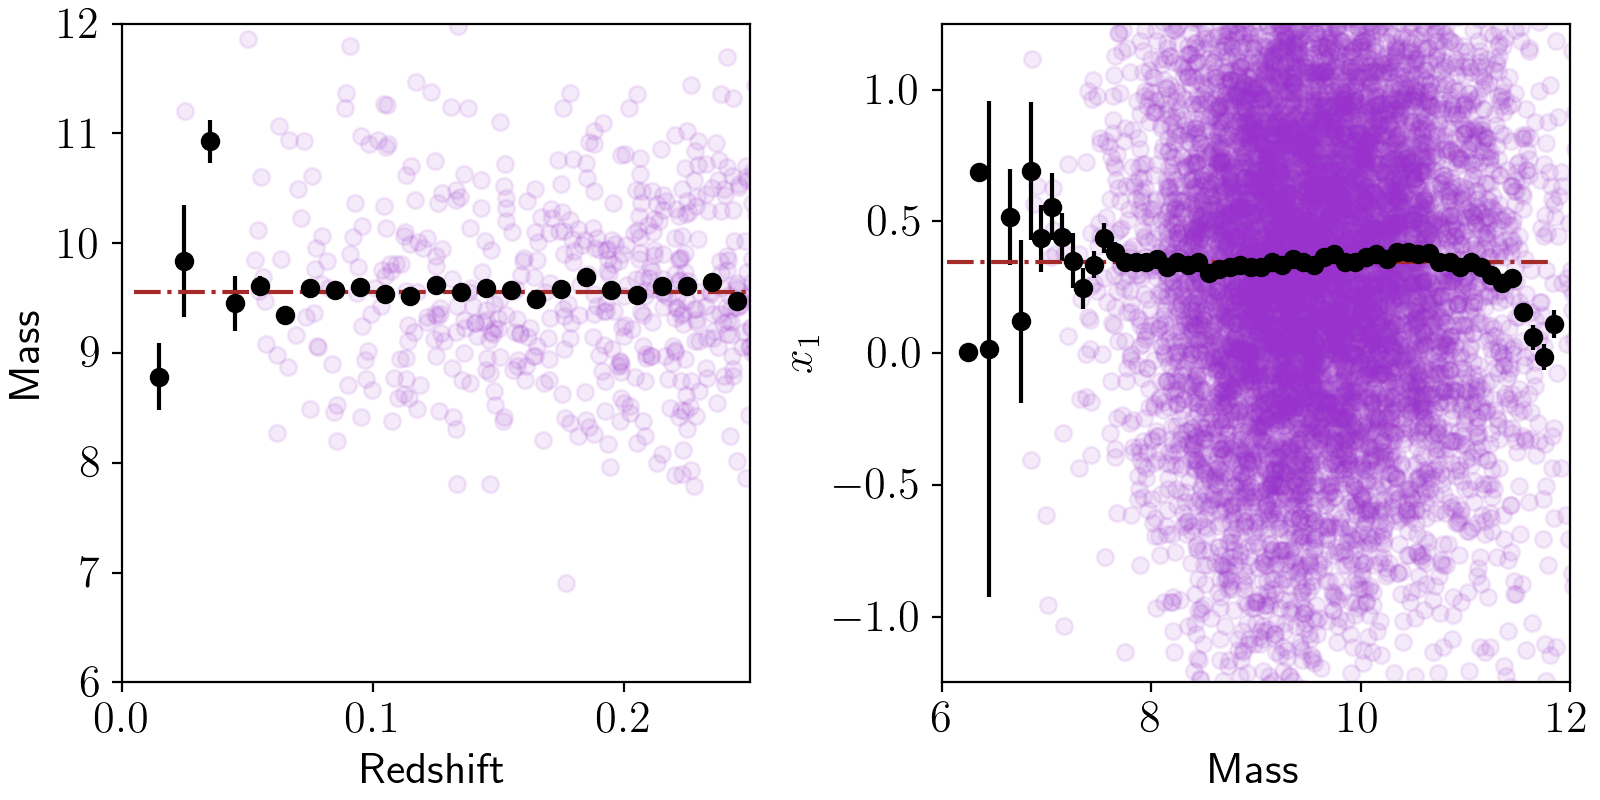

<ipython-input-95-6d3624960ce3>:11: RuntimeWarning: invalid value encountered in true_divide
  hist_err   = hist_sigma/np.sqrt(hist_count)


(-1.25, 1.25)

In [99]:
HOSTLIB_fig = plt.figure(constrained_layout=True,figsize=(8,4))
widths = [1, 1]
heights = [1]
spec5 = HOSTLIB_fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights, wspace=0, hspace=0)

bins = np.arange(0,1.1,.01)
z_v_mass = hist(dfh.ZTRUE.values, dfh.LOGMASS.values, bins=bins)
dhl, dhl_err = z_v_mass.hist()
#
bins_m = np.arange(6,12.,.1)
mass_v_x1 = hist(dfh.LOGMASS.values, dfh.X1.values, bins=bins_m)
dhl_x1, dhl_err_x1 = mass_v_x1.hist()

#dhl = binned_statistic(dfh.ZTRUE.values, dfh.LOGMASS.values, bins=bins, statistic='median')[0]
#dhl_err = binned_statistic(dfh.ZTRUE.values, dfh.LOGMASS.values, bins=bins, statistic='std')[0]
#dhl_count = binned_statistic(dfh.ZTRUE.values, dfh.ZTRUE.values, bins=bins, statistic='count')[0]

subset = 10000
ax2 = HOSTLIB_fig.add_subplot(spec5[0, 0])
ax2.scatter(dfh.ZTRUE.values[0:subset], dfh.LOGMASS.values[0:subset], c='darkorchid', alpha=.1)
ax2.errorbar((bins[1:] + bins[:-1])/2., dhl,label='Data', yerr=dhl_err, fmt='o', c='black')
ax2.plot((bins[1:] + bins[:-1])/2., np.zeros_like(dhl)+np.median(dfh.LOGMASS.values), c='brown', ls='-.')
ax2.set_ylabel('Mass')
ax2.set_xlabel('Redshift')
ax2.set_ylim([6,12])
ax2.set_xlim([0.,0.25])
#ax2.set_yticks([-1.5,0,1.5])
#ax2.set_xticks([])

#------------------------------------------------
ax3 = HOSTLIB_fig.add_subplot(spec5[0, 1])
ax3.scatter(dfh.LOGMASS[0:subset].values, dfh.X1[0:subset].values, c='darkorchid', alpha=.1)
ax3.errorbar((bins_m[1:] + bins_m[:-1])/2., dhl_x1,label='Data', yerr=dhl_err_x1, fmt='o', c='black')
ax3.plot((bins_m[1:] + bins_m[:-1])/2., np.zeros_like(dhl_x1)+np.median(dfh.X1.values), c='brown', ls='-.')
ax3.set_ylabel('$x_1$')
ax3.set_xlabel('Mass')
ax3.set_xlim([6,12])
ax3.set_ylim([-1.25, 1.25])
#ax3.set_yticks([-1.5,0,1.5])
#ax3.set_xticks([])


In [97]:
print('Done')

Done


---------------------------------
## Testing
---------------------------------

### Open the LowZ HOSTLIB

In [76]:
dfh = pd.read_csv(HOSTLIB_DIR+'LOWZ-RIG.v4.HOSTLIB', delim_whitespace=True)
dfh

,VARNAMES:,GALID,RA_GAL,DEC_GAL,ZTRUE,g_obs,r_obs,i_obs,z_obs,Y_obs,n0_Sersic,a0_Sersic,b0_Sersic,a_rot,LOGMASS,LOGMASS_ERR,C,X1,SNMAGSHIFT,sSFR
0,GAL:,1,34.4579,-4.70279,0.055913,26.5384,25.7263,23.5751,22.6917,23.0340,0.5,0.286538,0.854813,86.6227,9.23965,0.2,-0.117959,0.315315,0.075075,1
1,GAL:,2,34.7423,-4.70316,0.086918,23.9878,23.6814,23.2397,22.9509,24.6508,0.5,0.974762,0.688614,-56.0862,9.15756,0.2,-0.091820,0.745746,0.131131,1
2,GAL:,3,34.9884,-4.70419,0.122167,22.6348,22.3853,21.8954,21.5255,21.2720,0.5,1.170100,1.135660,57.3089,8.65909,0.2,0.234351,1.066070,0.115115,1
3,GAL:,4,34.9154,-4.70552,0.112964,21.9055,20.4269,19.6386,19.2496,19.1131,0.5,0.878139,2.191860,12.9170,9.08866,0.2,0.238160,0.055055,0.103103,1
4,GAL:,5,34.3680,-4.70245,0.175255,23.9215,23.7939,23.8668,23.2683,23.2935,0.5,0.817530,1.112620,63.4521,11.21600,0.2,-0.098845,0.045045,-0.055055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119382,GAL:,121768,35.2091,-4.64516,0.089677,24.9937,23.7910,23.6053,23.7177,25.0863,0.5,0.737258,0.966949,-44.5278,8.87518,0.2,0.416614,0.305305,0.129129,1
119383,GAL:,121769,35.1148,-4.64467,0.153680,24.3996,23.9665,24.0550,24.0612,23.6265,0.5,1.214670,0.963510,-73.0130,10.03280,0.2,0.001390,0.935936,0.047047,1
119384,GAL:,121770,35.0709,-4.64475,0.078044,22.1724,21.8211,21.7360,21.6996,21.6434,0.5,1.670350,1.237650,80.5863,11.35840,0.2,0.151392,-0.905906,0.025025,0
119385,GAL:,121771,35.3632,-4.64445,0.083922,25.9503,25.9766,26.0107,25.0456,25.1246,0.5,0.713105,0.322164,89.7165,9.79125,0.2,0.089157,-0.085085,-0.009009,1


In [77]:
# Test we can match :) 
mass = np.arange(8,14.2,.01)
find_nearest(mass, dfh.LOGMASS.values[4])

322

## Loop over the HOSTLIB. 
For each object, take the redshift and draw a sample of masses. 
Find the nearest mass to the mass in the HOSTLIB and then associate the x1, HR and age
Print this into the HOSTLIB
This can be done much better

In [ ]:
x1list = []
snmagshift = []
age = []
offset = 1.0
for i in range(len(dfh)):
#for i in range(100):
    percent = i*100./len(dfh)
    if i % 10000 == 0:
        print(str(percent)+'% complete')
    pdmodel.draw_sample(z=dfh.ZTRUE.values[i], size=1000)
    loc = find_nearest(pdmodel.sample.mass.values, dfh.LOGMASS.values[i]+offset)
    x1list.append(pdmodel.sample.stretch.values[loc])
    snmagshift.append(pdmodel.sample.hr.values[loc])
    age.append(pdmodel.sample.age.values[loc])
    #print(dfh.LOGMASS.values[i]+offset, pdmodel.sample.age.values[loc])
#print(np.sum(age))
x1list = np.array(x1list)
dfh['X1'] = x1list
dfh['SNMAGSHIFT'] = snmagshift
dfh['sSFR'] = age

In [ ]:
OUTPUT_HOSTLIB = 'LOWZ-MassShift'+'{:02.0f}'.format(offset*10)+'.v4.HOSTLIB'
print(OUTPUT_HOSTLIB)
dfh.to_csv(HOSTLIB_DIR+OUTPUT_HOSTLIB, sep=' ', header=True, index=False, float_format='%g')